In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, random_state=0):
    
    np.random.seed(random_state)
    x = np.zeros((datanum, 10))
    for i in range(10):
        x[:, i:i+1] = np.random.uniform(0, 1,[datanum,1])
    x1, x2, x3, x4, x5, x6, x7, x8, x9, x10 = [x[:, [i]] for i in range(10)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
         + 0.1 * np.exp(-8 * x2 + 4)
         + 3 * np.sin(2 * np.pi * x3 * x4)
         + cliff(x5, x6)).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X1":{"type":'continuous'},
             'X2':{'type':'continuous'},
             'X3':{'type':'continuous'},
             'X4':{'type':'continuous'},
             'X5':{'type':'continuous'},
             'X6':{'type':'continuous'},
             'X7':{'type':'continuous'},
             'X8':{'type':'continuous'},
             'X9':{'type':'continuous'},
             'X10':{'type':'continuous'},
             'Y':{'type':'target'}}
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=5000, random_state=0)

## Train GAMI-Net 

In [36]:
model = GAMINet(meta_info=meta_info, interact_num=20, 
            interact_arch=[40] * 2, subnet_arch=[40] * 2, 
            lr_bp=0.001, batch_size=200, task_type=task_type, activation_func=tf.nn.tanh, 
            main_effect_epochs=2000, interaction_epochs=2000, tuning_epochs=0, early_stop_thres=100,
            heredity=True, loss_threshold=0.01, reg_clarity=0.0,
            verbose=True, val_ratio=0.2, random_state=0)
model.fit(train_x, train_y)

val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.12137, val loss: 0.12067
Main effects training epoch: 2, train loss: 0.11649, val loss: 0.11547
Main effects training epoch: 3, train loss: 0.10176, val loss: 0.10127
Main effects training epoch: 4, train loss: 0.09227, val loss: 0.09168
Main effects training epoch: 5, train loss: 0.08503, val loss: 0.08452
Main effects training epoch: 6, train loss: 0.07952, val loss: 0.07874
Main effects training epoch: 7, train loss: 0.07559, val loss: 0.07500
Main effects training epoch: 8, train loss: 0.06826, val loss: 0.06795
Main effects training epoch: 9, train loss: 0.05562, val loss: 0.05546
Main effects training epoch: 10, train loss: 0.05878, val loss: 0.05830
Main effects training epoch: 11, train loss: 0.04533, val loss: 0.04495
Main effects training epoch: 12, train loss: 0.04366, val loss: 0.04355
Main effects training e

Main effects training epoch: 117, train loss: 0.00992, val loss: 0.00993
Main effects training epoch: 118, train loss: 0.01006, val loss: 0.00996
Main effects training epoch: 119, train loss: 0.00989, val loss: 0.00975
Main effects training epoch: 120, train loss: 0.00998, val loss: 0.00993
Main effects training epoch: 121, train loss: 0.00989, val loss: 0.00985
Main effects training epoch: 122, train loss: 0.00987, val loss: 0.00982
Main effects training epoch: 123, train loss: 0.00990, val loss: 0.00983
Main effects training epoch: 124, train loss: 0.00994, val loss: 0.00976
Main effects training epoch: 125, train loss: 0.00993, val loss: 0.00982
Main effects training epoch: 126, train loss: 0.00995, val loss: 0.00992
Main effects training epoch: 127, train loss: 0.00995, val loss: 0.00991
Main effects training epoch: 128, train loss: 0.00995, val loss: 0.00980
Main effects training epoch: 129, train loss: 0.00991, val loss: 0.00991
Main effects training epoch: 130, train loss: 0.009

Main effects training epoch: 233, train loss: 0.00928, val loss: 0.00926
Main effects training epoch: 234, train loss: 0.00930, val loss: 0.00926
Main effects training epoch: 235, train loss: 0.00934, val loss: 0.00924
Main effects training epoch: 236, train loss: 0.00957, val loss: 0.00942
Main effects training epoch: 237, train loss: 0.00928, val loss: 0.00934
Main effects training epoch: 238, train loss: 0.00925, val loss: 0.00923
Main effects training epoch: 239, train loss: 0.00926, val loss: 0.00932
Main effects training epoch: 240, train loss: 0.00950, val loss: 0.00951
Main effects training epoch: 241, train loss: 0.00928, val loss: 0.00929
Main effects training epoch: 242, train loss: 0.00939, val loss: 0.00925
Main effects training epoch: 243, train loss: 0.00929, val loss: 0.00931
Main effects training epoch: 244, train loss: 0.00925, val loss: 0.00933
Main effects training epoch: 245, train loss: 0.00930, val loss: 0.00929
Main effects training epoch: 246, train loss: 0.009

Main effects training epoch: 349, train loss: 0.00929, val loss: 0.00926
Main effects training epoch: 350, train loss: 0.00918, val loss: 0.00922
Main effects training epoch: 351, train loss: 0.00928, val loss: 0.00953
Main effects training epoch: 352, train loss: 0.00932, val loss: 0.00927
Early stop at epoch 352, with validation loss: 0.00927
##########Stage 1: main effect training stop.##########
##########Stage 2: interaction training start.##########
Interaction training epoch: 1, train loss: 0.01641, val loss: 0.01643
Interaction training epoch: 2, train loss: 0.01025, val loss: 0.01022
Interaction training epoch: 3, train loss: 0.00921, val loss: 0.00925
Interaction training epoch: 4, train loss: 0.00930, val loss: 0.00935
Interaction training epoch: 5, train loss: 0.00927, val loss: 0.00933
Interaction training epoch: 6, train loss: 0.00922, val loss: 0.00925
Interaction training epoch: 7, train loss: 0.00918, val loss: 0.00925
Interaction training epoch: 8, train loss: 0.00918

Interaction training epoch: 111, train loss: 0.00701, val loss: 0.00676
Interaction training epoch: 112, train loss: 0.00700, val loss: 0.00674
Interaction training epoch: 113, train loss: 0.00727, val loss: 0.00697
Interaction training epoch: 114, train loss: 0.00714, val loss: 0.00690
Interaction training epoch: 115, train loss: 0.00706, val loss: 0.00681
Interaction training epoch: 116, train loss: 0.00701, val loss: 0.00672
Interaction training epoch: 117, train loss: 0.00703, val loss: 0.00681
Interaction training epoch: 118, train loss: 0.00700, val loss: 0.00674
Interaction training epoch: 119, train loss: 0.00702, val loss: 0.00679
Interaction training epoch: 120, train loss: 0.00714, val loss: 0.00687
Interaction training epoch: 121, train loss: 0.00726, val loss: 0.00700
Interaction training epoch: 122, train loss: 0.00701, val loss: 0.00677
Interaction training epoch: 123, train loss: 0.00703, val loss: 0.00677
Interaction training epoch: 124, train loss: 0.00714, val loss: 

Interaction training epoch: 226, train loss: 0.00701, val loss: 0.00678
Interaction training epoch: 227, train loss: 0.00696, val loss: 0.00674
Interaction training epoch: 228, train loss: 0.00701, val loss: 0.00676
Interaction training epoch: 229, train loss: 0.00698, val loss: 0.00670
Interaction training epoch: 230, train loss: 0.00696, val loss: 0.00673
Interaction training epoch: 231, train loss: 0.00696, val loss: 0.00676
Interaction training epoch: 232, train loss: 0.00697, val loss: 0.00672
Interaction training epoch: 233, train loss: 0.00699, val loss: 0.00674
Interaction training epoch: 234, train loss: 0.00696, val loss: 0.00672
Interaction training epoch: 235, train loss: 0.00697, val loss: 0.00673
Interaction training epoch: 236, train loss: 0.00696, val loss: 0.00670
Interaction training epoch: 237, train loss: 0.00702, val loss: 0.00680
Interaction training epoch: 238, train loss: 0.00701, val loss: 0.00676
Interaction training epoch: 239, train loss: 0.00696, val loss: 

## Visualization

In [31]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

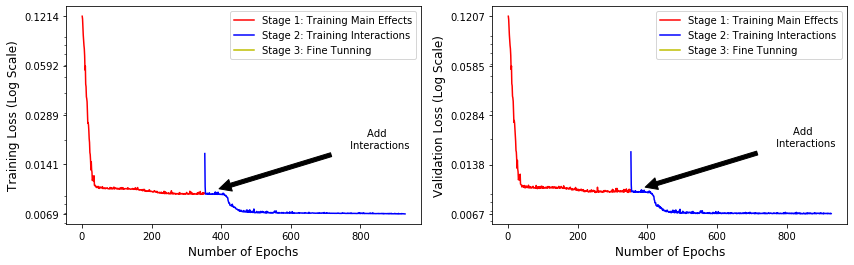

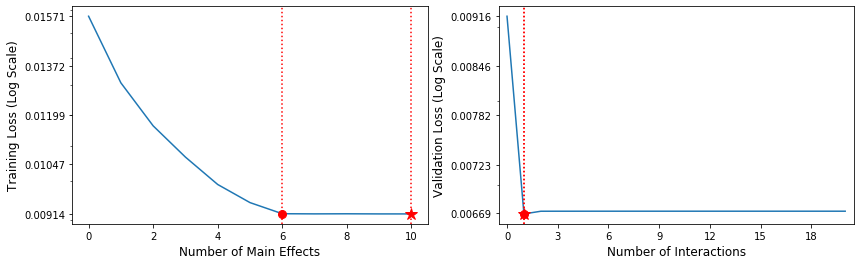

In [32]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

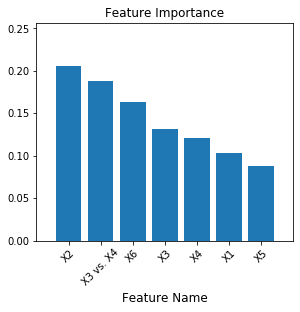

In [33]:
data_dict = model.global_explain(save_dict=False)
feature_importance_visualize(data_dict, save_png=True, folder=simu_dir, name='s1_feature')

Global Visualization

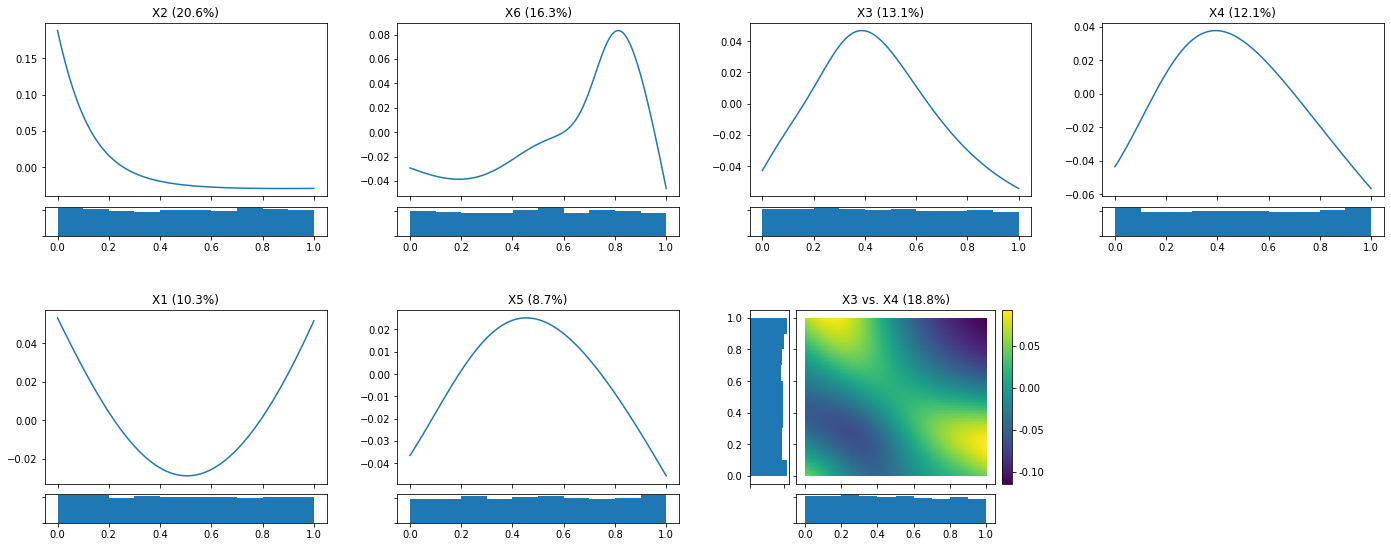

In [37]:
global_visualize_density(data_dict, save_png=True, folder=simu_dir, name='s1_global')

Interpret the prediction of a test sample

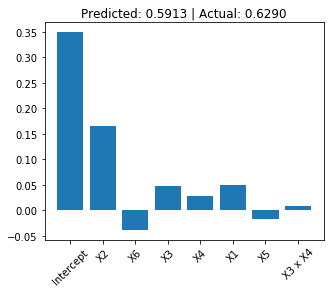

In [35]:
data_dict_local = model.local_explain(test_x[[0]], test_y[[0]], save_dict=False)
local_visualize(data_dict_local, save_png=True, folder=simu_dir, name='s1_local')